In [37]:
#Install prerequisite
!pip install pandas numpy sklearn matplotlib Minio psycopg2

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from urllib.parse import urlparse
import psycopg2, os
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

In [40]:
# Define S3 credentials
bucket_name = os.getenv('BUCKET_NAME', 'training-data')
cert_path = os.getenv('CERT_PATH', 'postgres.pem')
S3_ENDPOINT = os.getenv('S3_ENDPOINT', 'minio-service.kubeflow:9000')
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID', 'minio')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY', 'minio123')

# SSL certificates
if os.getenv('POSTGRES_SSL', '') == 'true': 
    sslmode='verify-full'
    sslrootcert='postgres.pem'
else:
    sslmode=None
    sslrootcert=None

In [ ]:
# Create S3 client
from minio import Minio
import re
url = re.compile(r"https?://")
cos = Minio(url.sub('', S3_ENDPOINT),
            access_key=AWS_ACCESS_KEY_ID,
            secret_key=AWS_SECRET_ACCESS_KEY,
            secure=False)

# Download CA certs if SSL connection is required
if os.getenv('POSTGRES_SSL', '') == 'true':
    cos.fget_object(bucket_name, cert_path, 'postgres.pem')

In [41]:
postgresURL=urlparse(os.getenv('POSTGRES_URL'))
print(postgresURL)
connection = psycopg2.connect(host=postgresURL.hostname,
                        port=postgresURL.port,
                        user=postgresURL.username,
                        password=postgresURL.password,
                        sslmode=sslmode,
                        sslrootcert=sslrootcert,
                        database=postgresURL.path.replace('/', ''))

ParseResult(scheme='postgresql', netloc='postgres:NwVZKF9ZrM@169.45.69.227:30684', path='/postgres', params='', query='', fragment='')


In [42]:
# Importing dataset - the generated simulator data
data = pd.read_sql_query('''SELECT measurement_time, temperature, target_temperature, ambiant_temperature, kilowatts, content_type, oxygen_level,nitrogen_level, carbon_dioxide_level, humidity_level, vent_1, vent_2, vent_3, time_door_open, defrost_cycle, maintenance_required  FROM reefer_telemetries;''',connection)
data.head()

,measurement_time,temperature,target_temperature,ambiant_temperature,kilowatts,content_type,oxygen_level,nitrogen_level,carbon_dioxide_level,humidity_level,vent_1,vent_2,vent_3,time_door_open,defrost_cycle,maintenance_required
0,2019-10-01 14:51:47.855765,5.49647,6.0,19.8447,3.44686,2,20.4543,79.4046,4.42579,60.3148,True,True,True,0.822024,6,0
1,2019-10-01 14:56:47.855765,5.07723,6.0,19.4884,3.23174,2,20.9098,77.6452,3.16873,60.5367,True,True,True,-0.334360,5,0
2,2019-10-01 15:01:47.855765,5.87840,6.0,19.8751,2.20399,2,22.4998,79.5565,4.99290,58.8380,True,True,True,1.494130,4,0
3,2019-10-01 15:06:47.855765,4.64850,6.0,20.8985,2.23505,2,22.0914,77.8230,5.25538,58.5273,True,True,True,1.515400,5,0
4,2019-10-01 15:11:47.855765,8.03803,6.0,18.1844,4.04437,2,20.7208,76.4794,4.22356,59.1736,True,True,True,0.795851,6,0


In [5]:
# Clean bad rows
data=data.dropna()
data.head()

,measurement_time,temperature,target_temperature,ambiant_temperature,kilowatts,content_type,oxygen_level,nitrogen_level,carbon_dioxide_level,humidity_level,vent_1,vent_2,vent_3,time_door_open,defrost_cycle,maintenance_required
0,2019-10-01 14:51:47.855765,5.49647,6.0,19.8447,3.44686,2,20.4543,79.4046,4.42579,60.3148,True,True,True,0.822024,6,0
1,2019-10-01 14:56:47.855765,5.07723,6.0,19.4884,3.23174,2,20.9098,77.6452,3.16873,60.5367,True,True,True,-0.334360,5,0
2,2019-10-01 15:01:47.855765,5.87840,6.0,19.8751,2.20399,2,22.4998,79.5565,4.99290,58.8380,True,True,True,1.494130,4,0
3,2019-10-01 15:06:47.855765,4.64850,6.0,20.8985,2.23505,2,22.0914,77.8230,5.25538,58.5273,True,True,True,1.515400,5,0
4,2019-10-01 15:11:47.855765,8.03803,6.0,18.1844,4.04437,2,20.7208,76.4794,4.22356,59.1736,True,True,True,0.795851,6,0


In [6]:
# Convert dataset into array for the independent variables (features)
X = np.asarray(data[['temperature','target_temperature','ambiant_temperature','oxygen_level','carbon_dioxide_level','humidity_level','nitrogen_level','vent_1','vent_2','vent_3','kilowatts','content_type','time_door_open','defrost_cycle']])
X[0:5]

array([[5.49647, 6.0, 19.8447, 20.4543, 4.42579, 60.3148, 79.4046, True,
        True, True, 3.44686, 2, 0.822024, 6],
       [5.07723, 6.0, 19.4884, 20.9098, 3.16873, 60.5367, 77.6452, True,
        True, True, 3.23174, 2, -0.33436, 5],
       [5.8784, 6.0, 19.8751, 22.4998, 4.9929, 58.838, 79.5565, True,
        True, True, 2.20399, 2, 1.49413, 4],
       [4.6485, 6.0, 20.8985, 22.0914, 5.25538, 58.5273, 77.823, True,
        True, True, 2.23505, 2, 1.5154, 5],
       [8.03803, 6.0, 18.1844, 20.7208, 4.22356, 59.1736, 76.4794, True,
        True, True, 4.04437, 2, 0.795851, 6]], dtype=object)

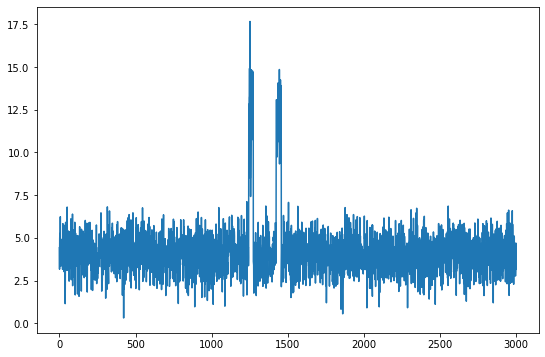

In [7]:
# Visualize the time series for co2 censor
fig,ax = plt.subplots(figsize=(9,6))
time_axe = np.arange(0,data['carbon_dioxide_level'].size,1)
ax.plot(time_axe,np.asarray(data[['carbon_dioxide_level']]))
plt.show()

In [8]:
# Convert dataset into array for the dependent (objective) variables
y = np.asarray(data['maintenance_required'])
y [0:5]

array([0, 0, 0, 0, 0])

In [9]:
# Normalize/standardize (mean = 0 and standard deviation = 1) 
# your features before applying machine learning techniques.
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.50110393,  0.        , -0.14773899, -0.1629678 ,  0.1649538 ,
         0.29855912,  1.41529895,  0.17281816,  0.17281816,  0.17281816,
         0.76298531,  0.        , -0.20228355,  1.37413104],
       [-0.92273506,  0.        , -0.50509519,  0.07873942, -0.6404113 ,
         0.52288849, -0.37061578,  0.17281816,  0.17281816,  0.17281816,
         0.56360643,  0.        , -1.38312527,  0.47970858],
       [-0.1169956 ,  0.        , -0.11724887,  0.92245946,  0.52828617,
        -1.194409  ,  1.56948813,  0.17281816,  0.17281816,  0.17281816,
        -0.38893935,  0.        ,  0.4840376 , -0.41471388],
       [-1.35391031,  0.        ,  0.90918485,  0.70574546,  0.69645017,
        -1.50851057, -0.19013627,  0.17281816,  0.17281816,  0.17281816,
        -0.36015212,  0.        ,  0.50575747,  0.47970858],
       [ 2.0549518 ,  0.        , -1.81296072, -0.02155183,  0.03539038,
        -0.85513483, -1.55398476,  0.17281816,  0.17281816,  0.17281816,
         1.31677332,  0.  

In [10]:
## randomly split the dataset into train and test to estimate model accuracy 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (2400, 14) (2400,)
Test set: (600, 14) (600,)


In [11]:
## As we are trying to acheive a binary classification, we use Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
## Predict using the trained LR model
predictions = LR.predict(X_test)
predictions


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,

In [13]:
## the accuracy metric: correct predictions / total number of records
score = LR.score(X_test,y_test)
score

0.9966666666666667

In [14]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.95273577, 0.04726423],
       [0.81328758, 0.18671242],
       [0.92197053, 0.07802947],
       ...,
       [0.96074115, 0.03925885],
       [0.83291284, 0.16708716],
       [0.73156798, 0.26843202]])

In [15]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, predictions)

0.9487179487179487

In [16]:
# Plot the confusion matrix to present the true value versus the predicted one per class
# 
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    print(confusion_matrix(y_test, predictions, labels=[1,0]))

Confusion matrix, without normalization
[[ 37   1]
 [  1 561]]
[[ 37   1]
 [  1 561]]


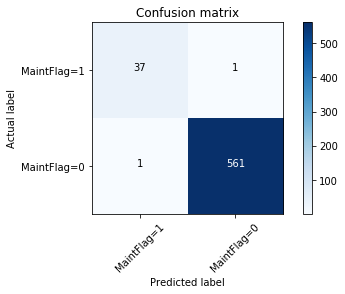

In [17]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['MaintFlag=1','MaintFlag=0'],normalize= False,  title='Confusion matrix')

In [27]:
print (classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       562
           1       0.97      0.97      0.97        38

    accuracy                           1.00       600
   macro avg       0.99      0.99      0.99       600
weighted avg       1.00      1.00      1.00       600



In [25]:
# Compute cross entropy loss for the ground truth and the predicted probability 
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)


0.10970816886508289

In [21]:
import pickle

#serializing our model to a file called model_logistic_regression.pkl
pickle.dump(LR, open("model_logistic_regression.pkl","wb"))

In [ ]:
# Store model into S3 storage

cos.fput_object(bucket_name, 'model_logistic_regression.pkl', 'model_logistic_regression.pkl')